Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-densenet121-mnist.ipynb)

Code Modules, Classes & Functions

In [1]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,urllib,zipfile
from tensorflow import image as timage
from torchvision.datasets import CIFAR10 as tcifar10
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torch.utils.data.dataset import Subset
import torch.nn as tnn
import torch.utils.checkpoint as tcp
from collections import OrderedDict as od
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [2]:
class TData(tds):
    def __init__(self,X,y):   
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        train_img,train_lbl=self.X[index],self.y[index]
        return train_img,train_lbl
    def __len__(self):
        return self.y.shape[0]

In [3]:
def load_h5py(fpath,zf,img_size):
    input_file=urllib.request.urlopen(fpath+zf)
    output_file=open(zf,'wb'); 
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
    zipf=zipfile.ZipFile(zf,'r')
    zipf.extractall(''); zipf.close()
    f=h5py.File(zf[:-4],'r')
    keys=list(f.keys()); print(keys)
    x=np.array(f[keys[1]],dtype='float32')/255
    x=x.reshape(-1,3,img_size,img_size)
    y=np.array(f[keys[2]],dtype='int32')-1
    N=len(y); n=int(.2*N)
    shuffle_ids=np.arange(N)
    np.random.RandomState(23).shuffle(shuffle_ids)
    x,y=x[shuffle_ids],y[shuffle_ids]
    x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
    y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [x_train.dtype,x_valid.dtype,x_test.dtype],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [y_train.dtype,y_valid.dtype,y_test.dtype]],
                    columns=['train','valid','test'],
                    index=['image shape','image type',
                           'label shape','label type'])
    display(df)    
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test]]

In [4]:
def display_examples(data_loader,img_size):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(11,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size,3))
        break
def show_image(img):
    npimg=img.numpy()/2.+.5; tr=(1,2,0)
    pl.figure(figsize=(10,2))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
def show_examples(data_loader,classes,num_examples):
    dataiter=iter(data_loader)
    images,labels=dataiter.next()
    show_image(utils.make_grid(images[0:num_examples]))
    print('^'.join('%9s'%classes[labels[j]] 
                   for j in range(num_examples)),end='^')

In [5]:
def model_acc(model,data_loader):
    model.eval()
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader,valid_loader,test_loader]
    if int(n)==2:
        data_loader=\
        [train_loader2,valid_loader2,test_loader2]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))

## Data

In [6]:
random_seed=12; batch_size=128
train_ids=torch.arange(0,44000)
valid_ids=torch.arange(44000,50000)
tr0=(.5,.5,.5)
transform=transforms\
.Compose([transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
train_valid=tcifar10(root='data',transform=transform,
                     download=True,train=True)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tcifar10(root='data',train=False, 
              transform=transform)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
valid_loader=tdl(dataset=valid,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Extracting data/cifar-10-python.tar.gz to data


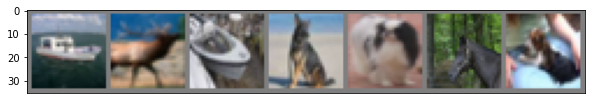


     ship^     deer^     ship^      dog^      dog^    horse^      dog^

In [7]:
classes=('plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck')
show_examples(valid_loader,classes,7)

In [8]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
[[x_train,x_valid,x_test],
 [y_train,y_valid,y_test]]=\
load_h5py(fpath,zf,32)

['backgrounds', 'images', 'labels']


,train,valid,test
image shape,"(8514, 3, 32, 32)","(2838, 3, 32, 32)","(2838, 3, 32, 32)"
image type,float32,float32,float32
label shape,"(8514,)","(2838,)","(2838,)"
label type,int32,int32,int32


Image dimensions: torch.Size([128, 3, 32, 32])
Label dimensions: torch.Size([128])


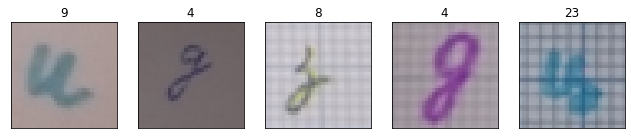

In [9]:
random_seed=23; batch_size2=128
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,
                  batch_size=batch_size2,shuffle=True)
valid_loader2=tdl(dataset=valid2,
                  batch_size=batch_size2,shuffle=True)
test_loader2=tdl(dataset=test2,
                 batch_size=batch_size2,shuffle=False)
display_examples(valid_loader2,32)

## DenseNet

In [10]:
def _bn_function_call(norm,relu,conv):
    def bn_function(*inputs):
        concated_features=torch.cat(inputs,1)
        bottleneck_output=conv(relu(norm(concated_features)))
        return bottleneck_output
    return bn_function
class _DenseLayer(tnn.Sequential):
    def __init__(self,num_input_features,growth_rate,
                 bn_size,drop_rate,memory_efficient=False):
        super(_DenseLayer,self).__init__()
        self.add_module('norm1',
                        tnn.BatchNorm2d(num_input_features)),
        self.add_module('relu1',tnn.ReLU(inplace=True)),
        self.add_module('conv1',\
        tnn.Conv2d(num_input_features,bn_size*growth_rate,
                   kernel_size=1,stride=1,bias=False)),
        self.add_module('norm2',
                        tnn.BatchNorm2d(bn_size*growth_rate)),
        self.add_module('relu2',tnn.ReLU(inplace=True)),
        self.add_module('conv2',\
        tnn.Conv2d(bn_size*growth_rate,growth_rate,
                   kernel_size=3,stride=1,
                   padding=1,bias=False)),
        self.drop_rate=drop_rate
        self.memory_efficient=memory_efficient
    def forward(self,*prev_features):
        bn_function=_bn_function_call(self.norm1,
                                      self.relu1,self.conv1)
        if self.memory_efficient and \
        any(prev_feature.requires_grad \
            for prev_feature in prev_features):
            bottleneck_output=tcp.checkpoint(bn_function,*prev_features)
        else:
            bottleneck_output=bn_function(*prev_features)
        new_features=self.conv2(self.relu2(
            self.norm2(bottleneck_output)))
        if self.drop_rate>0:
            new_features=tnn.functional.dropout(new_features,\
            p=self.drop_rate,training=self.training)
        return new_features

In [11]:
class _DenseBlock(tnn.Module):
    def __init__(self,num_layers,num_input_features,
                 bn_size, growth_rate,drop_rate,
                 memory_efficient=False):
        super(_DenseBlock,self).__init__()
        for i in range(num_layers):
            layer=_DenseLayer(
                num_input_features+i*growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,drop_rate=drop_rate,
                memory_efficient=memory_efficient)
            self.add_module('denselayer%d'%(i+1),layer)
    def forward(self,init_features):
        features=[init_features]
        for name,layer in self.named_children():
            new_features=layer(*features)
            features.append(new_features)
        return torch.cat(features,1)
class _Transition(tnn.Sequential):
    def __init__(self,num_input_features,num_output_features):
        super(_Transition,self).__init__()
        self.add_module('norm',
                        tnn.BatchNorm2d(num_input_features))
        self.add_module('relu',tnn.ReLU(inplace=True))
        self.add_module('conv',\
        tnn.Conv2d(num_input_features,num_output_features,
                   kernel_size=1,stride=1,bias=False))
        self.add_module('pool',
                        tnn.AvgPool2d(kernel_size=2,stride=2))   

In [12]:
class DenseNN121(tnn.Module):
    def __init__(self,growth_rate=32,block_config=(6,12,24,16),
                 num_init_featuremaps=64,bn_size=4,drop_rate=0,
                 num_classes=1000,memory_efficient=False,
                 grayscale=False):
        super(DenseNN121,self).__init__()
        if grayscale: in_channels=1
        else: in_channels=3       
        self.features=tnn.Sequential(od([
            ('conv0',tnn.Conv2d(in_channels=in_channels,
                                out_channels=num_init_featuremaps,
                                kernel_size=7,stride=2,
                                padding=3,bias=False)),
            ('norm0',tnn.BatchNorm2d(num_features=num_init_featuremaps)),
            ('relu0',tnn.ReLU(inplace=True)),
            ('pool0',tnn.MaxPool2d(kernel_size=3,stride=2,padding=1))]))
        num_features=num_init_featuremaps
        for i,num_layers in enumerate(block_config):
            block=_DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,drop_rate=drop_rate,
                growth_rate=growth_rate,
                memory_efficient=memory_efficient)
            self.features.add_module('denseblock%d'%(i+1),block)
            num_features=num_features+num_layers*growth_rate
            if i!=len(block_config)-1:
                trans=_Transition(num_input_features=num_features,
                                  num_output_features=num_features//2)
                self.features.add_module('transition%d'%(i+1),trans)
                num_features=num_features//2
        self.features.add_module('norm5',tnn.BatchNorm2d(num_features))
        self.classifier=tnn.Linear(num_features,num_classes)
        for m in self.modules():
            if isinstance(m,tnn.Conv2d):
                tnn.init.kaiming_normal_(m.weight)
            elif isinstance(m,tnn.BatchNorm2d):
                tnn.init.constant_(m.weight,1)
                tnn.init.constant_(m.bias,0)
            elif isinstance(m,tnn.Linear):
                tnn.init.constant_(m.bias,0)
    def forward(self,x):
        y=self.features(x)
        y=tnn.functional.relu(y,inplace=True)
        y=tnn.functional.adaptive_avg_pool2d(y,(1,1))
        y=torch.flatten(y,1)
        logits=self.classifier(y)
        probs=tnn.functional.softmax(logits,dim=1)
        return logits,probs

## Training

In [13]:
random_seed=34; num_classes=10
epochs=20; learning_rate=.001
grayscale=False
model=DenseNN121(num_classes=num_classes,
                 grayscale=grayscale)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate) 

In [14]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%100:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader),
                   model_acc(model,valid_loader)))

In [15]:
%train_run 20

Epoch: 001/020 | Batch 000/343 | Cost: 2.3008
Epoch: 001/020 | Batch 100/343 | Cost: 1.5324
Epoch: 001/020 | Batch 200/343 | Cost: 1.2544
Epoch: 001/020 | Batch 300/343 | Cost: 1.0122
Epoch: 001/020 train acc: 59.06% valid acc: 56.25%
Epoch: 002/020 | Batch 000/343 | Cost: 0.9587
Epoch: 002/020 | Batch 100/343 | Cost: 1.1749
Epoch: 002/020 | Batch 200/343 | Cost: 0.9979
Epoch: 002/020 | Batch 300/343 | Cost: 1.0449
Epoch: 002/020 train acc: 70.46% valid acc: 66.62%
Epoch: 003/020 | Batch 000/343 | Cost: 0.7682
Epoch: 003/020 | Batch 100/343 | Cost: 0.9417
Epoch: 003/020 | Batch 200/343 | Cost: 0.9523
Epoch: 003/020 | Batch 300/343 | Cost: 0.7621
Epoch: 003/020 train acc: 77.77% valid acc: 71.32%
Epoch: 004/020 | Batch 000/343 | Cost: 0.7007
Epoch: 004/020 | Batch 100/343 | Cost: 0.6437
Epoch: 004/020 | Batch 200/343 | Cost: 0.6037
Epoch: 004/020 | Batch 300/343 | Cost: 0.6366
Epoch: 004/020 train acc: 81.67% valid acc: 72.70%
Epoch: 005/020 | Batch 000/343 | Cost: 0.4862
Epoch: 005/020

In [16]:
%print_acc 1

Train accuracy: 97.7977%
Valid accuracy: 76.0333%
Test accuracy: 75.4900%


In [17]:
random_seed=45; num_classes=33
learning_rate=.001; grayscale=False
model=DenseNN121(num_classes=num_classes,
                 grayscale=grayscale)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [18]:
@register_line_magic
def train_run2(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader2):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets.long())
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train2)//batch_size2,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader2),
                   model_acc(model,valid_loader2)))

In [19]:
%train_run2 30

Epoch: 001/030 | Batch 000/066 | Cost: 3.5762
Epoch: 001/030 | Batch 050/066 | Cost: 3.0663
Epoch: 001/030 train acc: 13.48% valid acc: 12.26%
Epoch: 002/030 | Batch 000/066 | Cost: 2.7211
Epoch: 002/030 | Batch 050/066 | Cost: 2.1728
Epoch: 002/030 train acc: 14.34% valid acc: 12.76%
Epoch: 003/030 | Batch 000/066 | Cost: 2.3436
Epoch: 003/030 | Batch 050/066 | Cost: 2.2417
Epoch: 003/030 train acc: 26.30% valid acc: 23.96%
Epoch: 004/030 | Batch 000/066 | Cost: 1.8377
Epoch: 004/030 | Batch 050/066 | Cost: 1.7172
Epoch: 004/030 train acc: 35.76% valid acc: 31.89%
Epoch: 005/030 | Batch 000/066 | Cost: 1.4980
Epoch: 005/030 | Batch 050/066 | Cost: 1.4468
Epoch: 005/030 train acc: 37.56% valid acc: 32.03%
Epoch: 006/030 | Batch 000/066 | Cost: 1.2465
Epoch: 006/030 | Batch 050/066 | Cost: 1.1005
Epoch: 006/030 train acc: 61.29% valid acc: 49.30%
Epoch: 007/030 | Batch 000/066 | Cost: 0.8822
Epoch: 007/030 | Batch 050/066 | Cost: 1.2728
Epoch: 007/030 train acc: 49.47% valid acc: 40.03%

In [20]:
%print_acc 2

Train accuracy: 87.2563%
Valid accuracy: 62.7555%
Test accuracy: 62.9669%
